Progress Report 3: Enhanced CNN for Bounding Box Prediction with Dynamic Denoising

1. Loading and preprocessing data with infrared transformation.
2. Implementing dynamic denoising within the CNN to reduce noise impact during training.
3. Training the model to predict bounding boxes with denoising effect.
4. Testing and visualizing bounding box predictions to validate model effectiveness.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import random

2024-10-25 13:34:01.774856: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data Loading and Preprocessing

In [14]:
BASE_DIR = './train_data'
NOISE_FOLDERS = ['high_noise', 'little_noise', 'moderate_noise']
annotation_file = os.path.join(BASE_DIR, 'combined_annotations.csv')

def load_data_with_noise(annotation_file, base_dir=BASE_DIR, noise_folders=NOISE_FOLDERS):
    annotations = pd.read_csv(annotation_file)
    images = []
    labels = []
    image_types = []
    source_counts = {folder: 0 for folder in noise_folders}
    source_counts['train_data'] = 0

    for _, row in annotations.iterrows():
        img_filename = row['filename']
        folder_choice = random.choice([base_dir] + [os.path.join(base_dir, folder) for folder in noise_folders])
        img_path = os.path.join(folder_choice, img_filename)
        
        if not os.path.exists(img_path):
            img_path = os.path.join(base_dir, img_filename)
            source_counts['train_data'] += 1
            image_type = 'base'
        else:
            folder_key = os.path.basename(folder_choice)
            source_counts[folder_key] += 1
            image_type = folder_key
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image = cv2.resize(image, (512, 512))
            images.append(image[..., np.newaxis])
            # Normalize bounding box labels by dividing by 512
            labels.append([row['xmin'] / 512, row['ymin'] / 512, row['xmax'] / 512, row['ymax'] / 512])
            image_types.append(image_type)
    
    print("Data loaded from each source:", source_counts)
    return np.array(images) / 255.0, np.array(labels), image_types

images, labels, image_types = load_data_with_noise(annotation_file)
x_train, x_test, y_train, y_test, train_types, test_types = train_test_split(
    images, labels, image_types, test_size=0.2, random_state=42)

print(f'Training samples: {x_train.shape[0]}, Testing samples: {x_test.shape[0]}')


Data loaded from each source: {'high_noise': 5, 'little_noise': 3, 'moderate_noise': 6, 'train_data': 6}
Training samples: 16, Testing samples: 4


Dynamic Denoising Layer

In [15]:
# Dynamic denoising function with print statement to indicate usage
def dynamic_denoise_layer(inputs):
    def denoise(image):
        variance = tf.image.total_variation(image)
        threshold = 5000  # Example threshold

        smoothed_image = tf.nn.conv2d(tf.expand_dims(image, 0), 
                                      filters=tf.constant([[1, 2, 1], [2, 4, 2], [1, 2, 1]], dtype=tf.float32)[..., np.newaxis, np.newaxis],
                                      strides=1, padding='SAME')
        smoothed_image = tf.squeeze(smoothed_image, axis=0)  # Remove batch dimension

        return tf.where(variance > threshold, smoothed_image, image)
    
    return tf.map_fn(denoise, inputs)


Building and Compiling the CNN Model with Denoising

In [22]:
# Model definition
def create_model(input_shape=(512, 512, 1)):  # Updated for grayscale
    inputs = Input(shape=input_shape)
    x = Lambda(dynamic_denoise_layer, output_shape=input_shape)(inputs)

    # Convolutional layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(4, activation='linear')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Create and summarize the model
model = create_model()
#model.summary()

Training the Model

In [23]:
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
history = model.fit(datagen.flow(x_train, y_train, batch_size=4), epochs=10, validation_data=(x_test, y_test))

Epoch 1/10


/Users/anthonydibenedetto/opt/anaconda3/envs/imageprocessing/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - loss: 4090.4294 - mae: 30.8998 - val_loss: 1.8635 - val_mae: 0.8935
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 1.7615 - mae: 0.9342 - val_loss: 0.2917 - val_mae: 0.4776
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.1309 - mae: 0.2935 - val_loss: 0.0891 - val_mae: 0.2511
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0577 - mae: 0.2002 - val_loss: 0.0537 - val_mae: 0.1988
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0282 - mae: 0.1282 - val_loss: 0.0434 - val_mae: 0.1732
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0336 - mae: 0.1322 - val_loss: 0.0414 - val_mae: 0.1779
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0462 - mae: 0.1393 - val_loss: 0.0353 - val_mae: 0.1557
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0276 - mae: 0.1362 - val_loss: 0.0384 - val_mae: 0.1671
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 0.0198 - mae: 0.1017 - val_loss: 0.0569 - val_ma

Testing and Visualizing Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
[[124.744255  73.11894  197.28127  175.10532 ]
 [217.422    125.41261  280.6263   199.91034 ]
 [123.442085  76.39435  164.10475  132.53291 ]
 [203.56543   83.1249   243.69917  176.9148  ]]


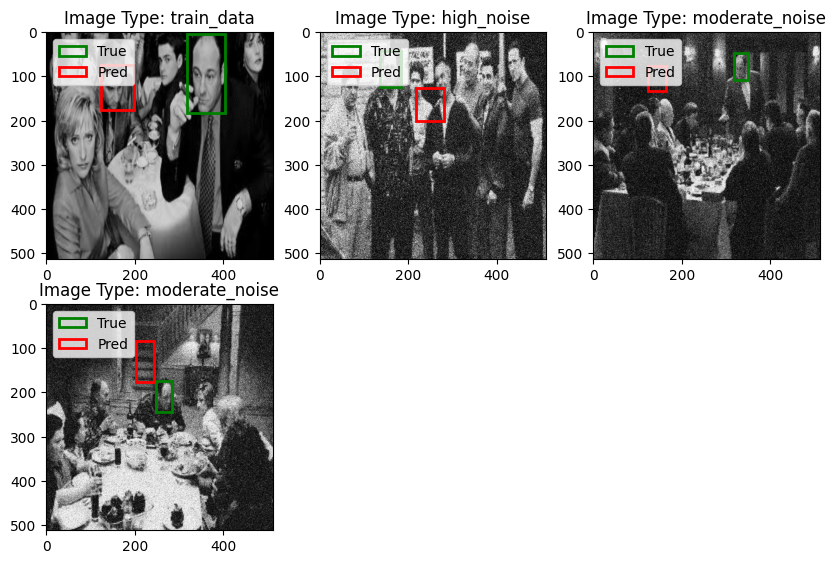

In [24]:
import matplotlib.pyplot as plt

# Updated visualization function with image type labeling and color conversion
def visualize_predictions(x_test, y_test, test_types, model):
    preds = model.predict(x_test) * 512  # Scale predictions back to pixel values
    print(preds)
    y_test = y_test * 512  # Scale ground truth labels back to pixel values
    num_images = min(5, len(x_test))
    
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        rgb_image = cv2.cvtColor((x_test[i] * 255).astype(np.uint8).squeeze(), cv2.COLOR_GRAY2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(rgb_image)
        plt.title(f'Image Type: {test_types[i]}')
        
        plt.gca().add_patch(
            plt.Rectangle((y_test[i][0], y_test[i][1]), y_test[i][2] - y_test[i][0], y_test[i][3] - y_test[i][1],
                          edgecolor='g', lw=2, fill=False, label='True')
        )
        
        plt.gca().add_patch(
            plt.Rectangle((preds[i][0], preds[i][1]), preds[i][2] - preds[i][0], preds[i][3] - preds[i][1],
                          edgecolor='r', lw=2, fill=False, label='Pred')
        )
        plt.legend(['True', 'Pred'], loc='upper left')
    plt.show()


# Visualize predictions with the updated function, passing test_types
visualize_predictions(x_test, y_test, test_types, model)
